
# AdventureWorks Product Analysis
Authored by: [Waleed](https://www.linkedin.com/in/waleedabdulla/)

## 1. Objectives
- Provide a __Managerial Overview__ of the revenue breakdown by products' features.
- __Rank__ products based on their __quantity sold, on their revenue and both quantity sold and revenue__.
- Based on revenue, show the best products, in each best model for each best subcategory in each category in each region.
- Conduct __Market Basket Analysis__ and show list of the products that are usually sold together using __association rule__.



## 2. Data Discovery & Collection

In [18]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# for ABC product analysis
import inventorize3 as inv

# for market basket analysis
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules


In [19]:
# import the sales tables from folder
path = r'../data/Sales'
sales_files = glob.glob(path+'/*.csv')
sales_list = []
for file in sales_files:
    df = pd.read_csv(file, index_col = None, header= 0)
    sales_list.append(df)
sales = pd.concat(sales_list, axis = 0, ignore_index = True)
# import products table from csv file
products = pd.read_csv('../data/AdventureWorks_Products.csv')
#import territories table from csv file
territories = pd.read_csv('../data/AdventureWorks_Territories.csv')
# import categories table from csv file
categories = pd.read_csv('../data/AdventureWorks_Product_Categories.csv')
# import subcategories tbale from csv file
subcategories = pd.read_csv('../data/AdventureWorks_Product_Subcategories.csv')

# make a list for tables
tables_list = [sales,products,territories,categories,subcategories]

# iterate over the tables-list and print info for each
for table in tables_list:
    print(table.info(),'\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50466 entries, 0 to 50465
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   OrderDate      50466 non-null  object
 1   StockDate      50466 non-null  object
 2   OrderNumber    50466 non-null  object
 3   ProductKey     50466 non-null  int64 
 4   CustomerKey    50466 non-null  int64 
 5   TerritoryKey   50466 non-null  int64 
 6   OrderLineItem  50466 non-null  int64 
 7   OrderQuantity  50466 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 3.1+ MB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293 entries, 0 to 292
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ProductKey             293 non-null    int64  
 1   ProductSubcategoryKey  293 non-null    int64  
 2   ProductSKU             293 non-null    object 
 3   ProductName            293 non-null


## 3. Data Preparation

In [79]:
# pproduct= purchased product

# merge the sales dataframe with the products data frame and assign that to sales_product
pproduct_analysis = sales.merge(
    products,left_on = 'ProductKey', right_on = 'ProductKey')

pproduct_analysis = pproduct_analysis.merge(
    subcategories, left_on = 'ProductSubcategoryKey', right_on = 'ProductSubcategoryKey')

pproduct_analysis = pproduct_analysis.merge(
    categories, left_on = 'ProductCategoryKey', right_on = 'ProductCategoryKey')


pproduct_analysis = pproduct_analysis.merge(
    territories, left_on ='TerritoryKey',right_on='SalesTerritoryKey')

# pproduct_analysis = pproduct_analysis[pproduct_analysis['Country']=='United States']

pproduct_analysis['Revenue'] = round(
    pproduct_analysis['ProductPrice']*pproduct_analysis['OrderQuantity'],2)

pproduct_analysis['Cost'] = round(
    pproduct_analysis['ProductCost']*pproduct_analysis['OrderQuantity'],2)

pproduct_analysis['GrossProfit'] = (pproduct_analysis['Revenue'] - pproduct_analysis['Cost'])

pproduct_analysis['GrossMargin'] = round(
    pproduct_analysis['GrossProfit']/pproduct_analysis['Revenue'],2)



pproduct_analysis['OrderDate'] = pd.to_datetime(pproduct_analysis['OrderDate'])

pproduct_analysis['StockDate'] = pd.to_datetime(pproduct_analysis['StockDate'])

pproduct_analysis['ProductShelfTime'] = (
    pproduct_analysis['OrderDate'] - pproduct_analysis['StockDate']).astype(str).\
    str.split(' ').\
    str.get(0).\
    astype(int)

pproduct_analysis.drop(
    ['TerritoryKey','ProductSubcategoryKey',
     'SalesTerritoryKey','ProductSubcategoryKey',
     'CustomerKey','Country','Continent'],
    axis=1,inplace=True)

pproduct_analysis.head()

,OrderDate,StockDate,OrderNumber,ProductKey,OrderLineItem,OrderQuantity,ProductSKU,ProductName,ModelName,ProductDescription,...,ProductPrice,SubcategoryName,ProductCategoryKey,CategoryName,Region,Revenue,Cost,GrossProfit,GrossMargin,ProductShelfTime
0,2015-01-01,2001-09-21,SO45080,332,1,1,BK-R50B-58,"Road-650 Black, 58",Road-650,Value-priced bike with many features of our to...,...,699.0982,Road Bikes,1,Bikes,Northwest,699.1,413.15,285.95,0.41,4850
1,2015-02-06,2001-10-12,SO45383,332,1,1,BK-R50B-58,"Road-650 Black, 58",Road-650,Value-priced bike with many features of our to...,...,699.0982,Road Bikes,1,Bikes,Northwest,699.1,413.15,285.95,0.41,4865
2,2015-07-27,2002-06-16,SO46896,332,1,1,BK-R50B-58,"Road-650 Black, 58",Road-650,Value-priced bike with many features of our to...,...,699.0982,Road Bikes,1,Bikes,Northwest,699.1,413.15,285.95,0.41,4789
3,2015-08-27,2002-06-21,SO47311,332,1,1,BK-R50B-58,"Road-650 Black, 58",Road-650,Value-priced bike with many features of our to...,...,699.0982,Road Bikes,1,Bikes,Northwest,699.1,413.15,285.95,0.41,4815
4,2015-09-09,2002-05-20,SO47507,332,1,1,BK-R50B-58,"Road-650 Black, 58",Road-650,Value-priced bike with many features of our to...,...,699.0982,Road Bikes,1,Bikes,Northwest,699.1,413.15,285.95,0.41,4860


In [80]:
# optimazing the storage
categorical_cols_names = [col for col in pproduct_analysis.select_dtypes(include= 'O').columns if col != 'OrderNumber']
for col in categorical_cols_names:
    pproduct_analysis[col] = pproduct_analysis[col].astype('category')

In [81]:
pproduct_analysis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50466 entries, 0 to 50465
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   OrderDate           50466 non-null  datetime64[ns]
 1   StockDate           50466 non-null  datetime64[ns]
 2   OrderNumber         50466 non-null  object        
 3   ProductKey          50466 non-null  int64         
 4   OrderLineItem       50466 non-null  int64         
 5   OrderQuantity       50466 non-null  int64         
 6   ProductSKU          50466 non-null  category      
 7   ProductName         50466 non-null  category      
 8   ModelName           50466 non-null  category      
 9   ProductDescription  50466 non-null  category      
 10  ProductColor        26230 non-null  category      
 11  ProductSize         50466 non-null  category      
 12  ProductStyle        50466 non-null  category      
 13  ProductCost         50466 non-null  float64   

## 4. Product Analysis

### Revenue per Order Summary Statistics & Distribution

       TotalRevenue
count   8653.000000
mean     913.729226
std     1028.546483
min        2.290000
25%       64.970000
50%      564.990000
75%     2049.100000
max     3578.270000


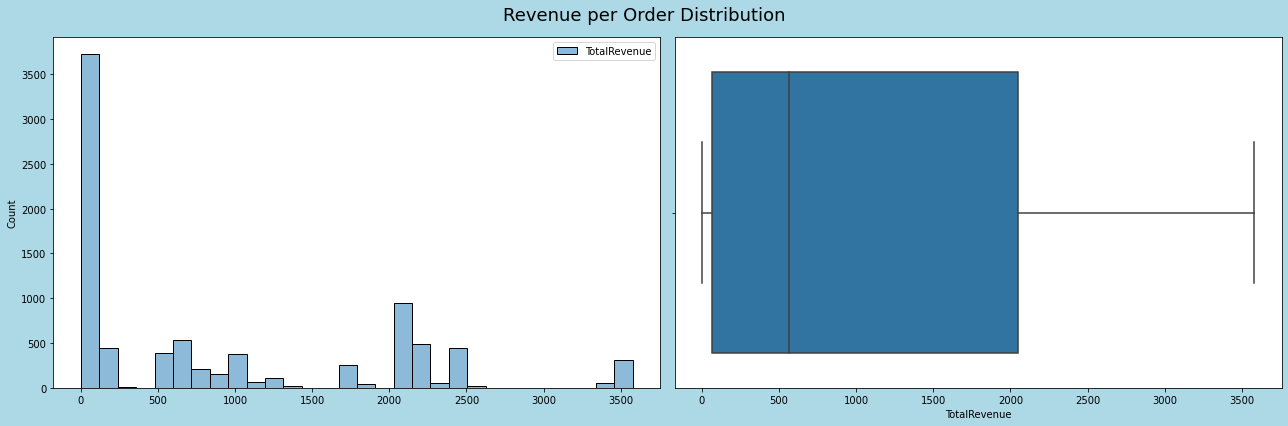

In [36]:
order_rev = pproduct_analysis[['OrderNumber','Revenue']].\
                groupby('OrderNumber').\
                agg(TotalRevenue=('Revenue','sum'))

print(order_rev.describe())

plt.figure(figsize=(18,6), facecolor='lightblue')
plt.suptitle('Revenue per Order Distribution', size= 18)
plt.subplot(1,2,1)
sns.histplot(data=order_rev, bins = 30)


plt.subplot(1,2,2)
sns.boxplot(x = order_rev['TotalRevenue'])

plt.tight_layout()
plt.show()

### Revenue by Product Category

              TotalRevenue
CategoryName              
Bikes           7437827.67
Accessories      327871.45
Clothing         140799.87


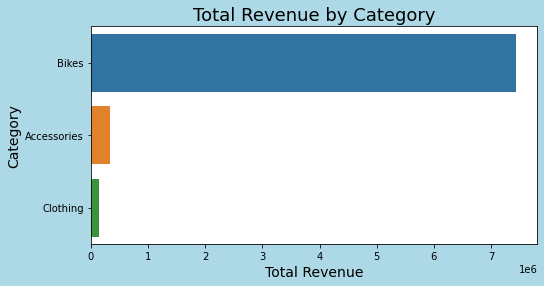

In [37]:
categories_rev = pproduct_analysis.loc[:,['CategoryName','Revenue']].\
                    groupby('CategoryName').\
                    agg(TotalRevenue=('Revenue','sum')).\
                    sort_values('TotalRevenue', ascending=False)
print(categories_rev)
plt.figure(figsize=(8,4),facecolor='lightblue')
plt.title('Total Revenue by Category', size=18)
sns.barplot(x=categories_rev['TotalRevenue'], 
            y=categories_rev.index, 
            order = categories_rev.index.tolist()
           )
plt.xlabel('Total Revenue', size=14)
plt.ylabel('Category', size=14)
plt.show()

In [38]:
best_categories_by_rev = categories_rev.index.tolist()[0]
print(f'Best category by Gross Profit is "{best_categories_by_rev}"')

Best category by Gross Profit is "Bikes"


### Revenue by Product Subcategories

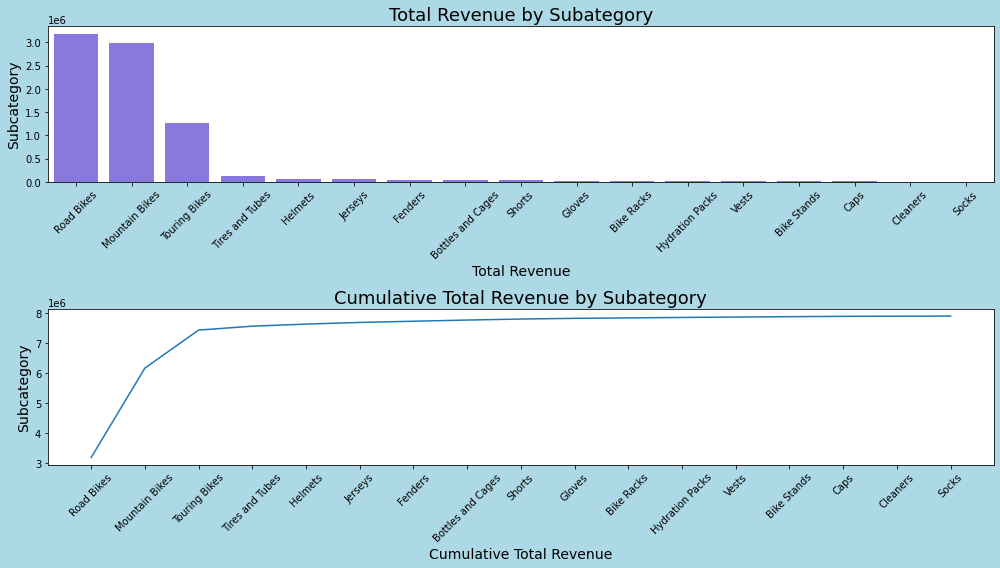

In [39]:
subcategories_rev = pproduct_analysis.loc[:,['SubcategoryName','Revenue']].\
                    groupby('SubcategoryName').\
                    agg(TotalRevenue=('Revenue','sum')).\
                    sort_values('TotalRevenue', ascending=False)
subcategories_rev['CumulativeTotalRevenue'] = subcategories_rev['TotalRevenue'].cumsum()


plt.figure(figsize=(14,8),facecolor='lightblue')

plt.subplot(2,1,1)
plt.title('Total Revenue by Subategory', size=18)
sns.barplot(x=subcategories_rev.index, 
            y='TotalRevenue',
            data = subcategories_rev,
            order = subcategories_rev.index,
            color='#7B68EE')
plt.xlabel('Total Revenue', size=14)
plt.ylabel('Subcategory', size=14)
plt.xticks(rotation=45)
plt.subplot(2,1,2)
plt.title('Cumulative Total Revenue by Subategory', size=18)
plt.plot(subcategories_rev.index,
         subcategories_rev['CumulativeTotalRevenue'])
plt.xlabel('Cumulative Total Revenue', size=14)
plt.ylabel('Subcategory', size=14)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

__Inference__\
The most important subcategories are "Road Bikes", "Mountain Bikes" and "Touring Bikes". They account for more than 80% of the revenue.

### Revenue by Model

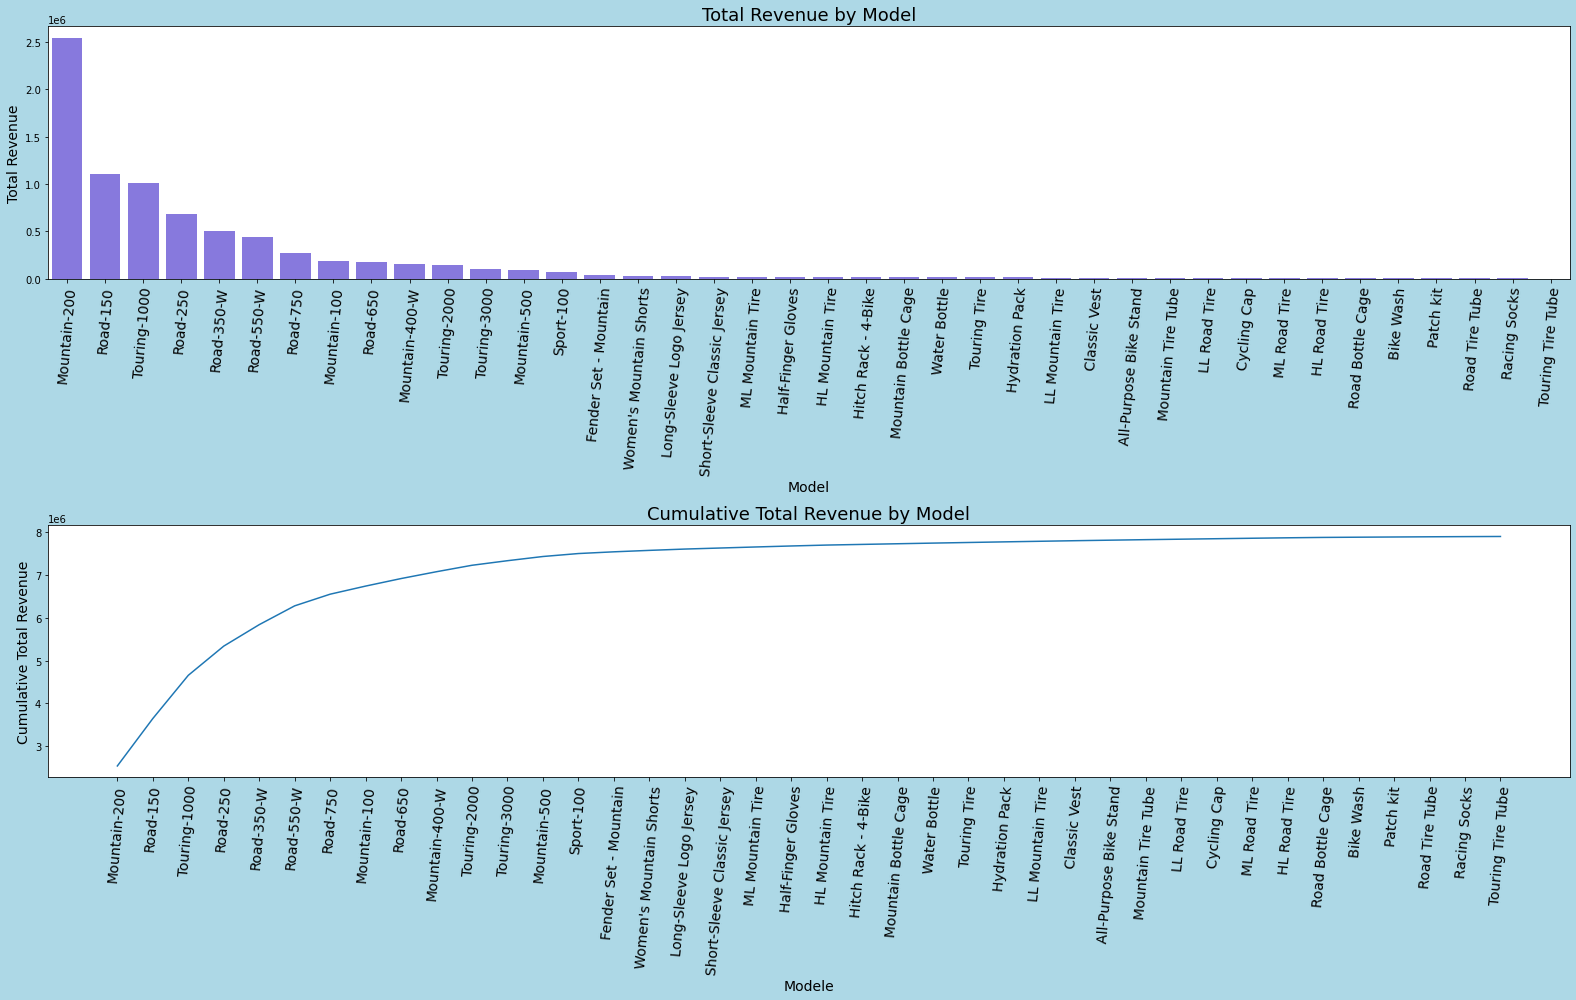

In [40]:
models_rev = pproduct_analysis.loc[:,['ModelName','Revenue']].\
                    groupby('ModelName').\
                    agg(TotalRevenue=('Revenue','sum')).\
                    sort_values('TotalRevenue', ascending=False)
models_rev['CumulativeTotalRevenue'] = models_rev['TotalRevenue'].cumsum()

plt.figure(figsize=(22,14), facecolor='lightblue')
plt.subplot(2,1,1)
plt.title('Total Revenue by Model', size=18)
sns.barplot(x=models_rev.index, 
            y='TotalRevenue',
            data = models_rev,
            order = models_rev.index,
            color='#7B68EE')
plt.xlabel('Model', size=14)
plt.ylabel('Total Revenue', size=14)
plt.xticks(size = 14,rotation=85)
plt.subplot(2,1,2)
plt.title('Cumulative Total Revenue by Model', size=18)
plt.plot(models_rev.index,
         models_rev['CumulativeTotalRevenue'])
plt.xlabel('Modele', size=14)
plt.ylabel('Cumulative Total Revenue', size=14)
plt.xticks(size = 14,rotation=85)

plt.tight_layout()
plt.show()

__Inference__\
The most important models which account for 80% of revenue are:
- 'Mountain-200'.
- 'Road-150'.
- 'Touring-1000'.
- 'Road-250'.
- 'Road-350-W'.
- 'Road-550-W'.
- 'Road-750'.
- 'Mountain-100'.
- 'Road-650'

### Top Products account for 80% of Revenue

In [41]:
products_rev = pproduct_analysis.loc[:,['ProductSKU','Revenue']].\
                    groupby('ProductSKU').\
                    agg(TotalRevenue=('Revenue','sum')).\
                    sort_values('TotalRevenue', ascending=False)
products_rev.index = [str(val) for val in products_rev.index]
products_rev['CumulativeTotalRevenue'] = products_rev['TotalRevenue'].cumsum()
products_rev['PercentofTotalRevenue'] = products_rev['TotalRevenue']/products_rev['TotalRevenue'].sum()
products_rev['CumulativePercentofTotalRevenue'] = products_rev['PercentofTotalRevenue'].cumsum()
iloc_index_80 = len(products_rev[products_rev['CumulativePercentofTotalRevenue'] >= 0.8])
products_rev.iloc[:iloc_index_80].index

Index(['BK-M68B-46', 'BK-M68S-42', 'BK-M68S-46', 'BK-M68S-38', 'BK-M68B-38',
       'BK-M68B-42', 'BK-R93R-48', 'BK-R93R-62', 'BK-R93R-52', 'BK-R93R-56',
       'BK-R93R-44', 'BK-T79Y-54', 'BK-T79U-54', 'BK-R79Y-42', 'BK-R79Y-40',
       'BK-T79U-60', 'BK-T79U-46', 'BK-T79Y-46', 'BK-T79U-50', 'BK-R89R-58',
       'BK-R79Y-44', 'BK-T79Y-50', 'BK-R89B-48', 'BK-R64Y-44', 'BK-R79Y-48',
       'BK-R89B-52', 'BK-R64Y-42', 'BK-R89B-44', 'BK-T79Y-60', 'BK-R89B-58',
       'BK-R64Y-48', 'BK-R19B-44', 'BK-R89R-48', 'BK-R64Y-38', 'BK-R64Y-40',
       'BK-R19B-52', 'BK-R19B-48', 'BK-R89R-52', 'BK-R89R-44', 'BK-M38S-38',
       'BK-R19B-58', 'BK-T44U-50', 'BK-T44U-46', 'BK-M82B-48', 'FE-6654',
       'BK-M38S-42', 'BK-M38S-40', 'BK-M38S-46', 'BK-T44U-54', 'BK-T44U-60',
       'TI-M602', 'BK-M82S-42', 'BK-M82S-38', 'HL-U509-R', 'BK-M82B-44',
       'BK-M82B-38', 'HL-U509-B', 'HL-U509', 'TI-M823', 'BK-M82S-48',
       'BK-R50B-58', 'BK-R50R-48', 'BK-M82B-42', 'BK-R50R-62', 'BK-R50R-58',
       'RA-H1

### Top 10 Products by Revenue

                         TotalRevenue
ProductName                          
Mountain-200 Black, 46      469243.90
Mountain-200 Silver, 42     430855.36
Mountain-200 Silver, 46     426712.52
Mountain-200 Silver, 38     410141.16
Mountain-200 Black, 38      403672.70
Mountain-200 Black, 42      397525.40
Road-150 Red, 48            254057.17
Road-150 Red, 62            239744.09
Road-150 Red, 52            229009.28
Road-150 Red, 56            203961.39


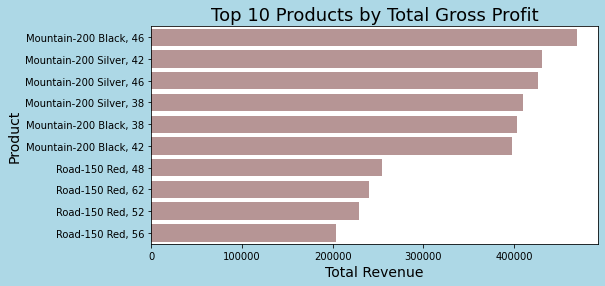

In [42]:
top10_products_rev = pproduct_analysis.loc[:,['ProductName','Revenue']].\
                    groupby('ProductName').\
                    agg(TotalRevenue=('Revenue','sum')).\
                    sort_values('TotalRevenue', ascending=False).\
                    head(10)
print(top10_products_rev)
plt.figure(figsize=(8,4),facecolor='lightblue')
plt.title('Top 10 Products by Total Gross Profit', size=18)
sns.barplot(x=top10_products_rev['TotalRevenue'], 
            y=top10_products_rev.index,
            order = top10_products_rev.index.tolist(),
            color='#BC8F8F')
plt.xlabel('Total Revenue', size=14)
plt.ylabel('Product', size=14)

plt.show()

### Bottom 10 Products by Revenue

                                TotalRevenue
ProductName                                 
Racing Socks, L                      1806.99
Racing Socks, M                      2238.51
Touring Tire Tube                    3318.35
Classic Vest, M                      4254.50
Classic Vest, S                      4572.00
Road Tire Tube                       4760.07
Classic Vest, L                      4762.50
Patch Kit/8 Patches                  4836.48
Bike Wash - Dissolver                5167.50
Short-Sleeve Classic Jersey, L       5884.91


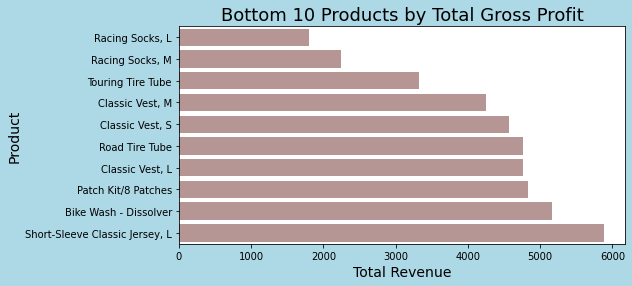

In [43]:
bottom10_products_rev = pproduct_analysis.loc[:,['ProductName','Revenue']].\
                    groupby('ProductName').\
                    agg(TotalRevenue=('Revenue','sum')).\
                    sort_values('TotalRevenue').\
                    head(10)
print(bottom10_products_rev)
plt.figure(figsize=(8,4),facecolor='lightblue')
plt.title('Bottom 10 Products by Total Gross Profit', size=18)
sns.barplot(x=bottom10_products_rev['TotalRevenue'], 
            y=bottom10_products_rev.index,
            order = bottom10_products_rev.index.tolist(),
            color='#BC8F8F')
plt.xlabel('Total Revenue', size=14)
plt.ylabel('Product', size=14)

plt.show()

### Product ABC Analysis

In [44]:
abc_analysis = (pproduct_analysis.loc[:,['ProductSKU','OrderQuantity','Revenue']].
                groupby('ProductSKU').agg(TotalQuantity=('OrderQuantity','sum'),
                                          TotalRevenue=('Revenue','sum')).
                reset_index()
               )
abc_analysis.head()

,ProductSKU,TotalQuantity,TotalRevenue
0,BC-M005,1538,15364.62
1,BC-R205,985,8855.15
2,BK-M18B-40,21,11339.79
3,BK-M18B-42,20,10799.80
4,BK-M18B-44,24,12959.76


In [45]:
a = inv. productmix(abc_analysis['ProductSKU'],
                     abc_analysis['TotalQuantity'],
                     abc_analysis['TotalRevenue']
                   )
a = a[['sales_category','revenue_category','product_mix']].\
        rename(columns={'sales_category':'QuantityRank',
                        'revenue_category':'RevenueRank',
                        'product_mix':'ProductRank'
                       }
              )
abc_analysis = pd.concat([abc_analysis,a],axis=1)
abc_analysis.head()

,ProductSKU,TotalQuantity,TotalRevenue,QuantityRank,RevenueRank,ProductRank
0,BC-M005,1538,15364.62,A,B,A_B
1,BC-R205,985,8855.15,A,C,A_C
2,BK-M18B-40,21,11339.79,C,C,C_C
3,BK-M18B-42,20,10799.80,C,C,C_C
4,BK-M18B-44,24,12959.76,C,B,C_B


In [46]:
prod_rank_name = {'A_A':'Margin & Volume Driver',
                  'A_B':'Volume Driver',
                  'A_C':'Volume Driver',
                  'B_A':'Margin Driver',
                  'B_B':'Regular',
                  'B_C':'Regular',
                  'C_A':'Margin Driver',
                  'C_B':'Regular',
                  'C_C':'Slow Moving'
                  }

abc_analysis['ProductRankName'] = abc_analysis['ProductRank'].map(prod_rank_name)
abc_analysis.head()

,ProductSKU,TotalQuantity,TotalRevenue,QuantityRank,RevenueRank,ProductRank,ProductRankName
0,BC-M005,1538,15364.62,A,B,A_B,Volume Driver
1,BC-R205,985,8855.15,A,C,A_C,Volume Driver
2,BK-M18B-40,21,11339.79,C,C,C_C,Slow Moving
3,BK-M18B-42,20,10799.80,C,C,C_C,Slow Moving
4,BK-M18B-44,24,12959.76,C,B,C_B,Regular


In [47]:
abc_analysis[['TotalQuantity','TotalRevenue']].describe(percentiles=[0.333,0.666])

,TotalQuantity,TotalRevenue
count,130.000000,130.000000
mean,228.061538,60819.223000
std,466.728126,96095.881543
min,4.000000,1806.990000
33.3%,29.000000,11183.434950
50%,62.500000,15779.650000
66.6%,124.624000,40487.444400
max,3029.000000,469243.900000


__Function to Visualize Total Product Count, Total Countity Sold and Total Revenue of from a Data Frame__

In [48]:
def make_count_qty_rev_vis(df,criteria):
    if criteria=='Qunatity':
        facecolor='#FFE4C4'
    elif criteria=='Revenue':
        facecolor='#F0E68C'
    else:
        facecolor='#E6E6FA'
        
    plt.figure(figsize=(22,14), facecolor=facecolor)
    plt.suptitle(f'Total Revenue, Total Quantity Sold and Total Product Count by {criteria} ABC Rank', 
                 size=24)
    
    plt.subplot(1,3,1)
    plt.title(f'Products Count by {criteria} ABC Rank', size=20)
    sns.barplot(x='TotalProductCount',
                y=df.index,
                color='#4682B4',
                order=df.index,
                orient='h',
                data=df
               )
    plt.xlabel('Total Product Count', color='black', size=18)
    plt.ylabel(f'{criteria} ABC Rank', color='black', size=18)
    plt.xticks(color='black', size = 18)
    plt.yticks(color='black', size = 18)
    
    
    plt.subplot(1,3,2)
    plt.title(f'Quantity Sold by {criteria} ABC Rank', size = 20)
    sns.barplot(x='TotalQuantitySold',
                y=df.index,
                color='#191970',
                order=df.index,
                orient='h',
                data=df
               )
    plt.xlabel('Total Quantity Sold', color='black', size=18)
    plt.ylabel('')
    plt.xticks(color='black', size = 18)
    plt.yticks(color='black', size = 18)
    
    
    plt.subplot(1,3,3)
    plt.title(f'Revenue by {criteria} ABC Rank', size=20)
    sns.barplot(x='TotalRevenue',
                y=df.index,
                color='#1E90FF',
                order=df.index,
                orient='h',
                data=df
               )
    plt.xlabel('Total Revenue', color='black', size=18)
    plt.ylabel('')
    plt.xticks(color='black', size = 18)
    plt.yticks(color='black', size = 18)
    
    plt.tight_layout()
    
    plt.show()

#### Aggregating 'TotalProductCount', 'TotalQuantitySold' and 'TotalRevenue' by Quantity-ABC-Rank

In [49]:
abc_qty_rank_agg = (abc_analysis.groupby('QuantityRank').
                     agg(TotalProductCount=('QuantityRank','count'),
                     TotalQuantitySold=('TotalQuantity','sum'),
                     TotalRevenue=('TotalRevenue','sum'))
                    )
abc_qty_rank_agg

,TotalProductCount,TotalQuantitySold,TotalRevenue
QuantityRank,,,
A,28,23622,1663263.66
B,41,4540,3981543.06
C,61,1486,2261692.27


#### Visualizing Total Product Count, Total Quantity Sold and Total Revenue by Quantity-ABC-Rank.

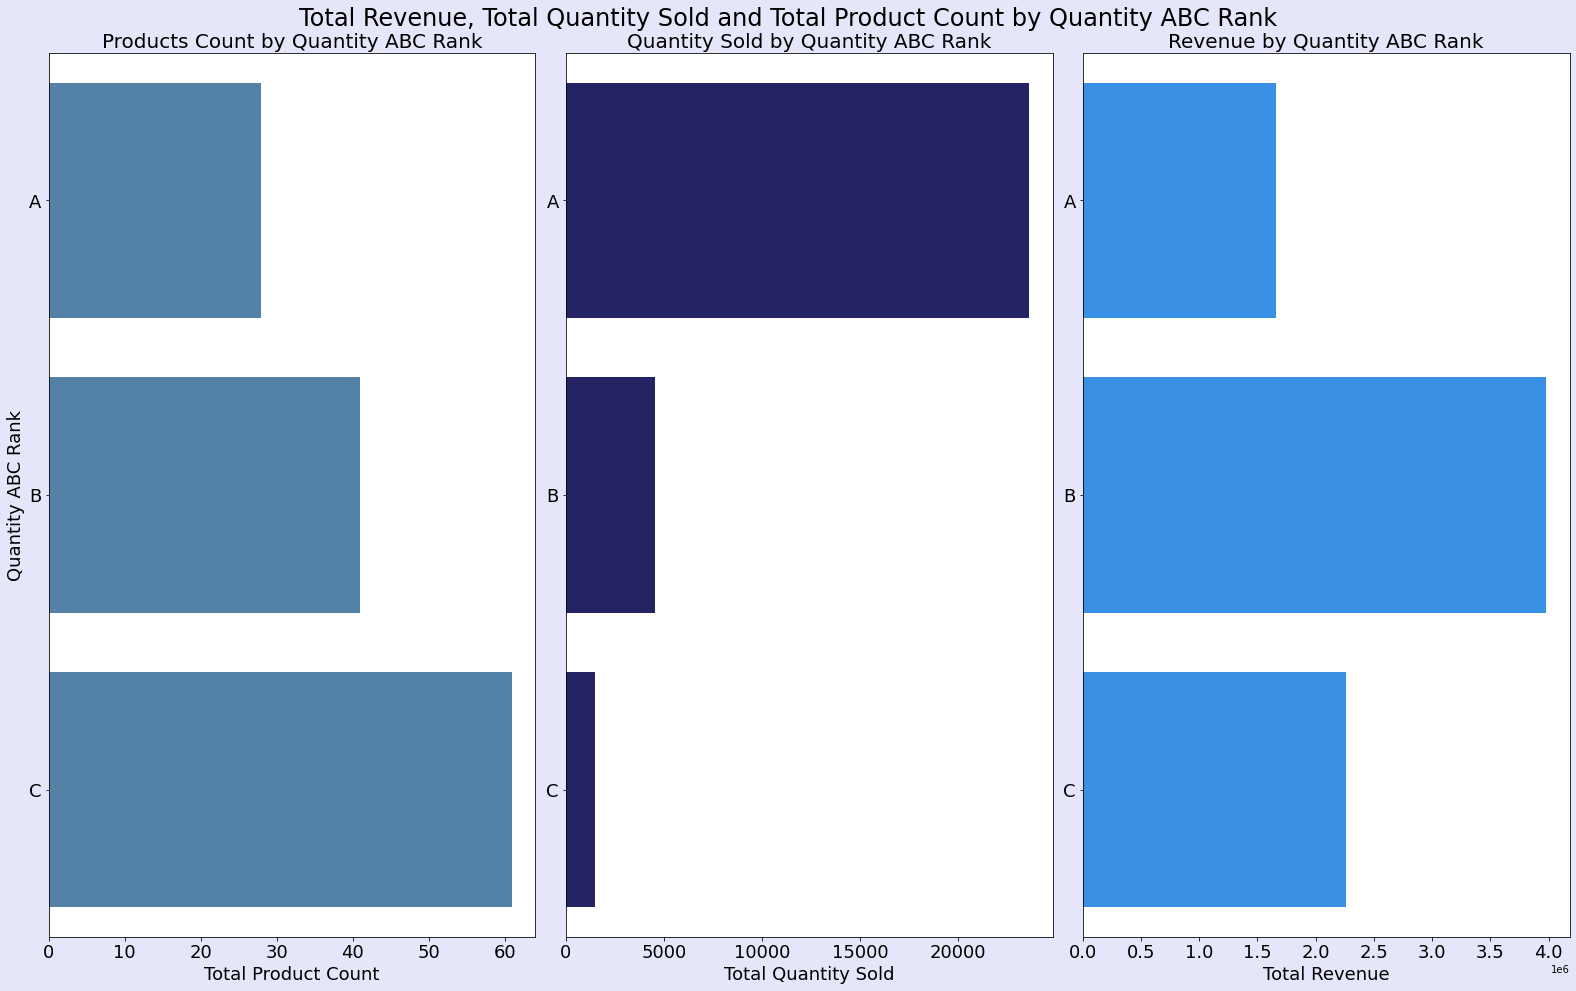

In [50]:
make_count_qty_rev_vis(abc_qty_rank_agg,'Quantity')

#### Aggregating 'TotalProductCount', 'TotalQuantitySold' and 'TotalRevenue' by Revenue-ABC-Rank

In [51]:
abc_rev_rank_agg = (abc_analysis.groupby('RevenueRank').
                     agg(TotalProductCount=('RevenueRank','count'),
                     TotalQuantitySold=('TotalQuantity','sum'),
                     TotalRevenue=('TotalRevenue','sum'))
                    )
abc_rev_rank_agg

,TotalProductCount,TotalQuantitySold,TotalRevenue
RevenueRank,,,
A,36,3237,6323224.62
B,45,12254,1177835.84
C,49,14157,405438.53


#### Visualizing Total Product Count, Total Quantity Sold and Total Revenue by Revenue-ABC-Rank.

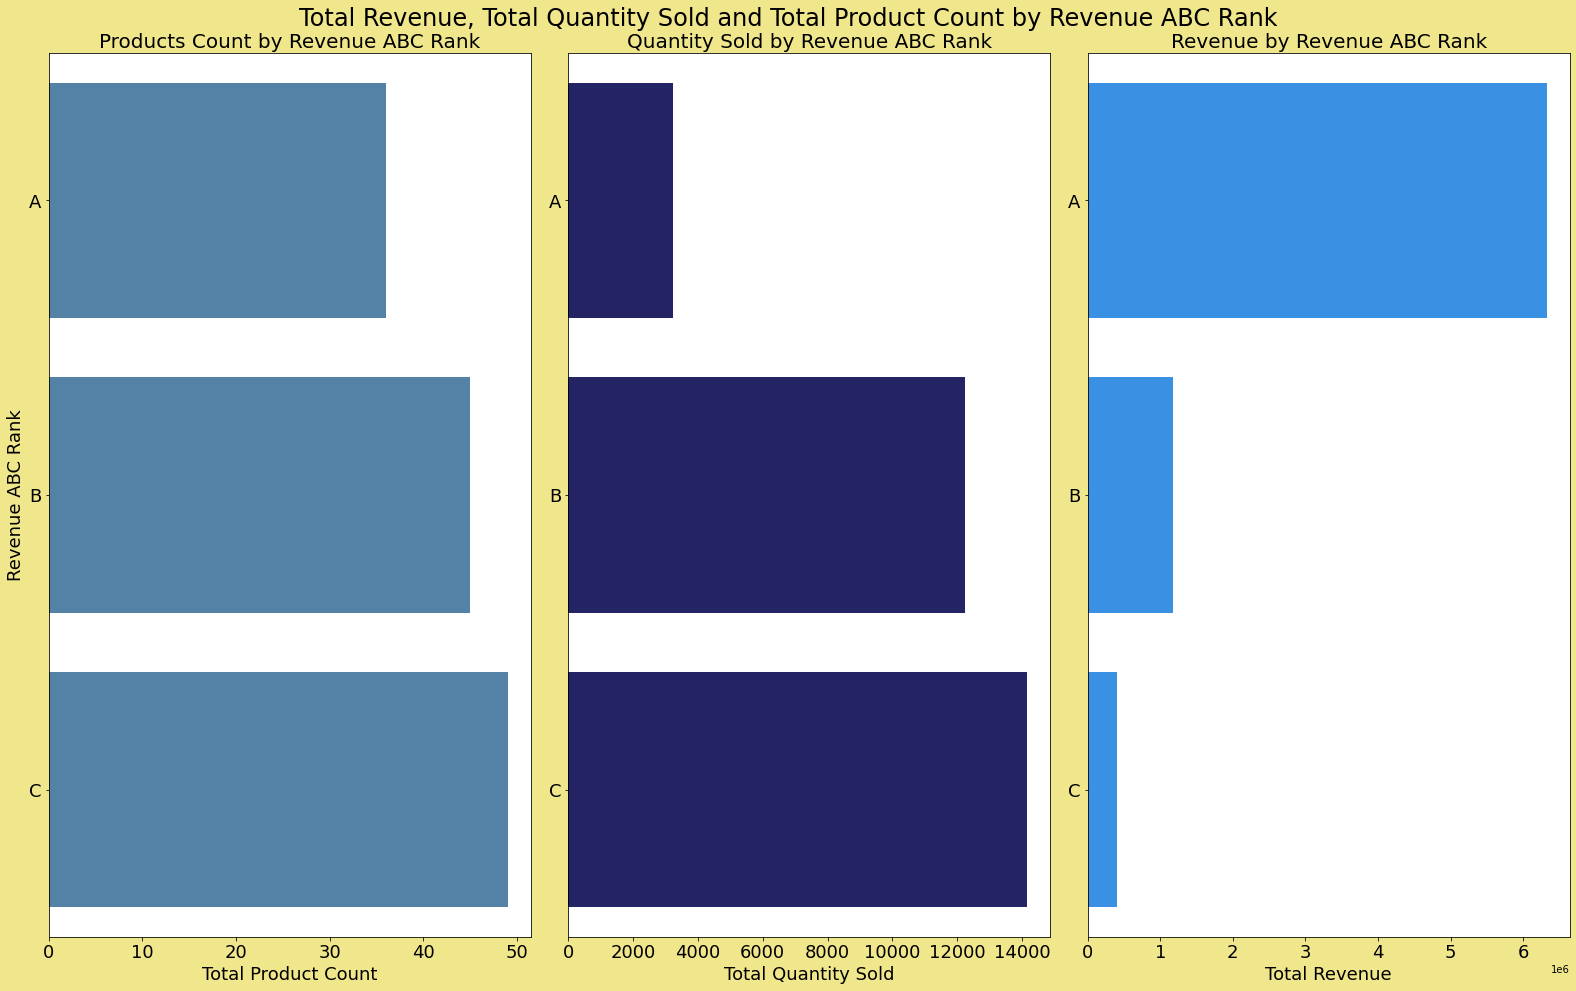

In [52]:
make_count_qty_rev_vis(abc_rev_rank_agg,'Revenue')

#### Aggregating 'TotalProductCount', 'TotalQuantitySold' and 'TotalRevenue' by Product-ABC-Rank

In [68]:
abc_prod_rank_agg = (abc_analysis.groupby('ProductRank').
                             agg(TotalProductCount=('ProductRank','count'),
                             TotalQuantitySold=('TotalQuantity','sum'),
                             TotalRevenue=('TotalRevenue','sum'))
                                )
abc_prod_rank_agg

,TotalProductCount,TotalQuantitySold,TotalRevenue
ProductRank,,,
A_A,3,643,1326811.78
A_B,11,11171,228503.37
A_C,14,11808,107948.51
B_A,21,2046,3673111.09
B_B,4,426,191692.53
B_C,16,2068,116739.44
C_A,12,548,1323301.75
C_B,30,657,757639.94
C_C,19,281,180750.58


#### Visualizing Total Product Count, Total Quantity Sold and Total Revenue by Product-ABC-Rank.

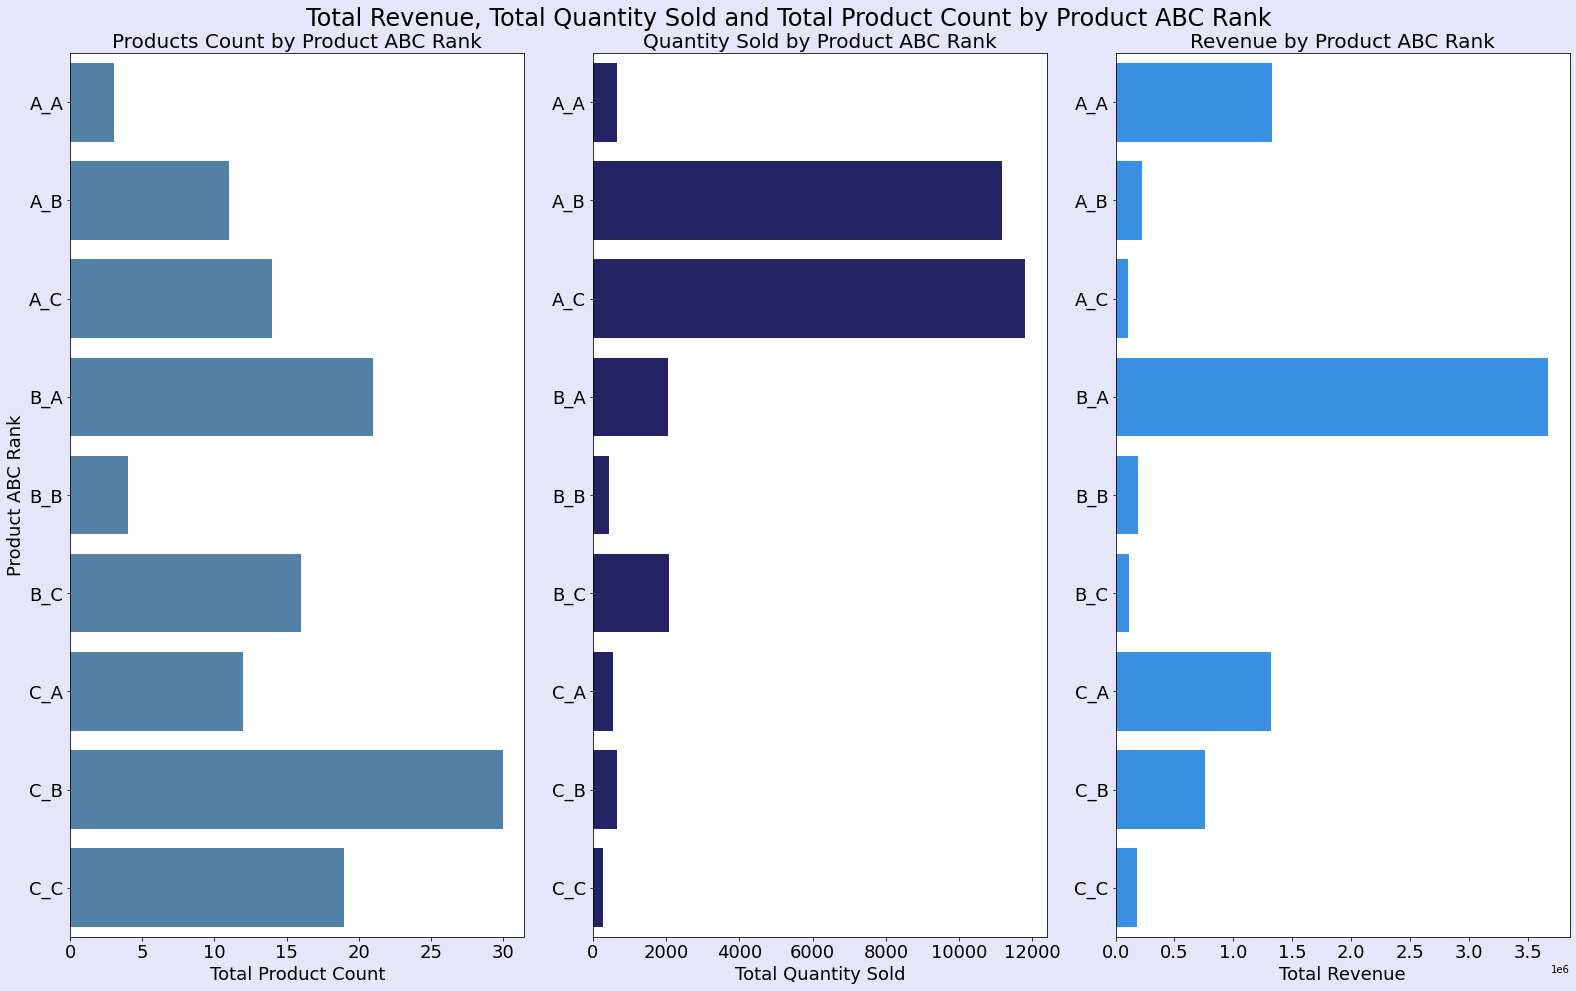

In [72]:
make_count_qty_rev_vis(abc_prod_rank_agg,'Product')

__Recommendation__\
Maintain excellent relationship with the suppliers of volume and revenue drivers products.

## 5. Region/Store Level Best Products

### Revenue by Porduct Categories in each Region

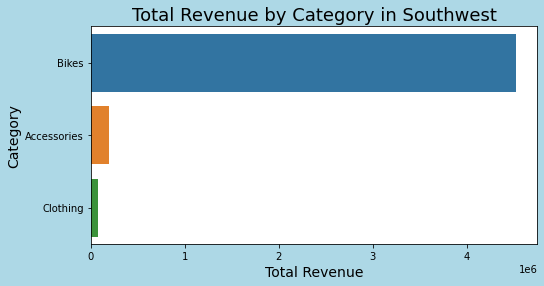

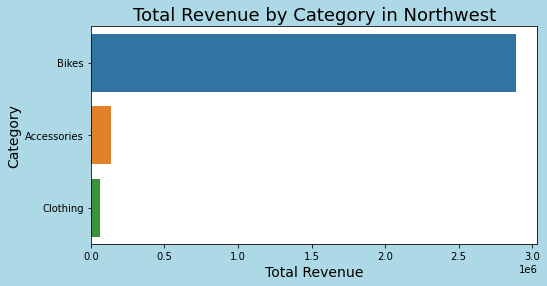

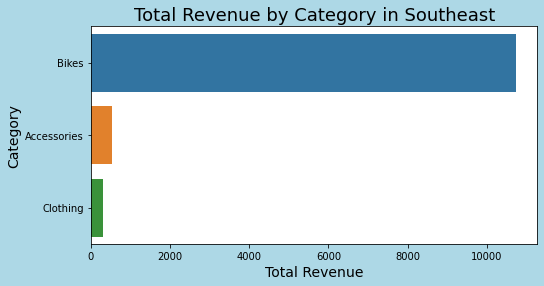

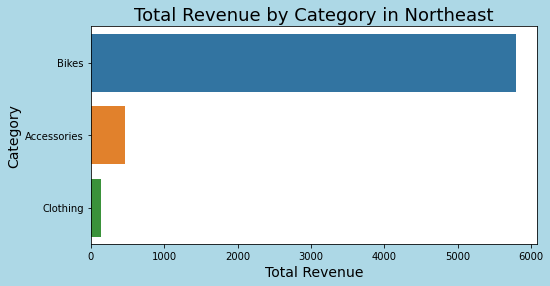

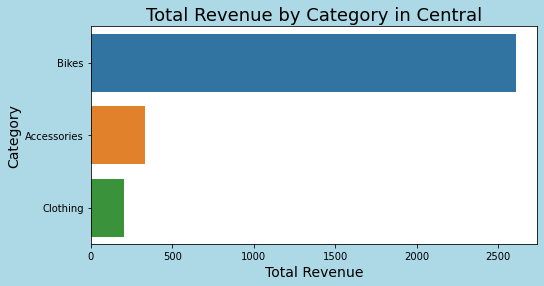

In [55]:
regions = pproduct_analysis['Region'].astype('O').value_counts().index.tolist()

for region in regions:
    region_df = pproduct_analysis.loc[pproduct_analysis['Region']==region,['CategoryName','Revenue']]
    best_category_in_region = region_df.\
                              groupby('CategoryName').\
                              agg(TotalRevenue=('Revenue','sum')).\
                              sort_values('TotalRevenue',ascending=False)
   
    plt.figure(figsize=(8,4),facecolor='lightblue')
    plt.title(f'Total Revenue by Category in {region}', size=18)
    sns.barplot(x=best_category_in_region['TotalRevenue'], 
                y=best_category_in_region.index, 
                order = best_category_in_region.index.tolist())
    plt.xlabel('Total Revenue', size=14)
    plt.ylabel('Category', size=14)
#     best_category_in_region = best_category_in_region.index.tolist()[0] 
#     print(f'Best category in {region} is {best_category_in_region}')

### Best Products in Best Models in Best Subcategories by Revenue in each Category in each Region

__Best Subcategory by Revenue in each Category in each Region__

In [56]:
best_subcategory_in_region_in_category = {'Region':[],'Category':[],'Subcategory':[]}

for region in pproduct_analysis['Region'].astype('O').value_counts().index.tolist():
    for category in pproduct_analysis['CategoryName'].astype('O').value_counts().index.tolist():
        region_condi = pproduct_analysis['Region']==region
        category_condi = pproduct_analysis["CategoryName"]==category
        region_category_df = pproduct_analysis.loc[(region_condi)&(category_condi),
                                                    ['SubcategoryName','Revenue']]
        
        best_subcategory_in_region_category = region_category_df.\
                                              groupby('SubcategoryName').\
                                              agg(TotalRevenue=('Revenue','sum')).\
                                              sort_values('TotalRevenue', ascending = False)
        
        best_subcategory_in_region_category = best_subcategory_in_region_category.index.tolist()[0]
        best_subcategory_in_region_in_category['Region'].append(region)
        best_subcategory_in_region_in_category['Category'].append(category)
        best_subcategory_in_region_in_category['Subcategory'].append(best_subcategory_in_region_category)
        
region_category_subcategory_df = pd.DataFrame(best_subcategory_in_region_in_category)
region_category_subcategory_pivoted_df = region_category_subcategory_df.\
                                            pivot('Region','Category').\
                                            loc[:,'Subcategory']
print('Best Subcategories by Revenue in each Category in each Region')
region_category_subcategory_pivoted_df

Best Subcategories by Revenue in each Category in each Region


Category,Accessories,Bikes,Clothing
Region,,,
Central,Tires and Tubes,Mountain Bikes,Jerseys
Northeast,Tires and Tubes,Mountain Bikes,Vests
Northwest,Tires and Tubes,Road Bikes,Jerseys
Southeast,Tires and Tubes,Mountain Bikes,Jerseys
Southwest,Tires and Tubes,Road Bikes,Jerseys


In [57]:
best_subcategories = {}
for index, row in region_category_subcategory_pivoted_df.iterrows():
    best_subcategories[index] = row.tolist()
for region in best_subcategories.keys():
    best_subcategories[region] =[val for val in best_subcategories[region] if str(val)!='nan']
for region in best_subcategories.keys():
    print(best_subcategories[region])

['Tires and Tubes', 'Mountain Bikes', 'Jerseys']
['Tires and Tubes', 'Mountain Bikes', 'Vests']
['Tires and Tubes', 'Road Bikes', 'Jerseys']
['Tires and Tubes', 'Mountain Bikes', 'Jerseys']
['Tires and Tubes', 'Road Bikes', 'Jerseys']


__Best Model in best Subcategory by Revenue in each Category in each Region__

In [58]:
best_model_in_region_in_subcategory = {'Region':[],'Subcategory':[],'Model':[]}

for region in best_subcategories.keys():
    for subcategory in best_subcategories[region]:
        region_condi = pproduct_analysis['Region']==region
        subcategory_condi = pproduct_analysis["SubcategoryName"]==subcategory
        region_subcategory_df = pproduct_analysis.loc[(region_condi)&(subcategory_condi),
                                                    ['ModelName','Revenue']]
        
        best_model_in_region_subcategory = (region_subcategory_df.\
                                            groupby('ModelName').\
                                            agg(TotalRevenue=('Revenue','sum')).\
                                            sort_values('TotalRevenue', ascending = False))
        
        best_model_in_region_subcategory = (best_model_in_region_subcategory.index.tolist()[0])
        
        best_model_in_region_in_subcategory['Region'].append(region)
        best_model_in_region_in_subcategory['Subcategory'].append(subcategory)
        best_model_in_region_in_subcategory['Model'].append(best_model_in_region_subcategory)
        
region_subcategory_model_df = pd.DataFrame(best_model_in_region_in_subcategory)
region_subcategory_model_pivoted_df = region_subcategory_model_df.\
                                            pivot('Region','Subcategory').\
                                            loc[:,'Model']
print('Best Models in best Subcategories by Revenue in each category in each Region')
region_subcategory_model_pivoted_df


Best Models in best Subcategories by Revenue in each category in each Region


Subcategory,Jerseys,Mountain Bikes,Road Bikes,Tires and Tubes,Vests
Region,,,,,
Central,Short-Sleeve Classic Jersey,Mountain-200,NaN,LL Road Tire,NaN
Northeast,NaN,Mountain-200,NaN,HL Mountain Tire,Classic Vest
Northwest,Long-Sleeve Logo Jersey,NaN,Road-150,ML Mountain Tire,NaN
Southeast,Long-Sleeve Logo Jersey,Mountain-200,NaN,HL Mountain Tire,NaN
Southwest,Long-Sleeve Logo Jersey,NaN,Road-150,ML Mountain Tire,NaN


In [59]:
best_models = {}
for index, row in region_subcategory_model_pivoted_df.iterrows():
    best_models[index] = row.tolist()
for region in best_models.keys():
    best_models[region] =[val for val in best_models[region] if str(val)!='nan']
for region in best_models.keys():
    print(best_models[region])  

['Short-Sleeve Classic Jersey', 'Mountain-200', 'LL Road Tire']
['Mountain-200', 'HL Mountain Tire', 'Classic Vest']
['Long-Sleeve Logo Jersey', 'Road-150', 'ML Mountain Tire']
['Long-Sleeve Logo Jersey', 'Mountain-200', 'HL Mountain Tire']
['Long-Sleeve Logo Jersey', 'Road-150', 'ML Mountain Tire']


__Best Product in best Model in best Subcategory by Revenue in each Category in each Region__

In [60]:
best_product_in_region_in_model = {'Region':[],'Model':[],'Product':[]}
for region in best_models.keys():
    for model in best_models[region]:
        region_condi = pproduct_analysis['Region']==region
        subcategory_condi = pproduct_analysis["ModelName"]==model
        region_model_df = pproduct_analysis.loc[(region_condi)&(subcategory_condi),
                                                    ['ProductName','Revenue']]
        
        best_product_in_region_model = (region_model_df.\
                                        groupby('ProductName').\
                                        agg(TotalRevenue=('Revenue','sum')).\
                                        sort_values('TotalRevenue', ascending = False))
        
        best_product_in_region_model = (
            best_product_in_region_model.index.tolist()[0])
        
        best_product_in_region_in_model['Region'].append(region)
        best_product_in_region_in_model['Model'].append(model)
        best_product_in_region_in_model['Product'].append(best_product_in_region_model)
        
region_model_product_df = pd.DataFrame(best_product_in_region_in_model)
region_model_product_pivoted_df = region_model_product_df.\
                                            pivot('Region','Model').\
                                            loc[:,'Product']
print('Best Product in best Models in best Subcateogries by Revenue in each Category in each Region')
region_model_product_pivoted_df
        

Best Product in best Models in best Subcateogries by Revenue in each Category in each Region


Model,Classic Vest,HL Mountain Tire,LL Road Tire,Long-Sleeve Logo Jersey,ML Mountain Tire,Mountain-200,Road-150,Short-Sleeve Classic Jersey
Region,,,,,,,,
Central,NaN,NaN,LL Road Tire,NaN,NaN,"Mountain-200 Silver, 38",NaN,"Short-Sleeve Classic Jersey, M"
Northeast,"Classic Vest, L",HL Mountain Tire,NaN,NaN,NaN,"Mountain-200 Black, 42",NaN,NaN
Northwest,NaN,NaN,NaN,"Long-Sleeve Logo Jersey, L",ML Mountain Tire,NaN,"Road-150 Red, 62",NaN
Southeast,NaN,HL Mountain Tire,NaN,"Long-Sleeve Logo Jersey, S",NaN,"Mountain-200 Silver, 38",NaN,NaN
Southwest,NaN,NaN,NaN,"Long-Sleeve Logo Jersey, L",ML Mountain Tire,NaN,"Road-150 Red, 48",NaN


In [61]:
bst_prod_in_bst_mdl_in_bst_subcate_in_cate_in_region = (
    region_model_product_df.merge(region_subcategory_model_df,
                                   left_on=['Region','Model'],
                                   right_on=['Region','Model']).\
        merge(region_category_subcategory_df,
              left_on=['Region','Subcategory'],
              right_on=['Region','Subcategory'])
        )
bst_prod_in_bst_mdl_in_bst_subcate_in_cate_in_region = (
            bst_prod_in_bst_mdl_in_bst_subcate_in_cate_in_region[['Region','Category',
                                                                  'Subcategory','Model',
                                                                   'Product']])
bst_prod_in_bst_mdl_in_bst_subcate_in_cate_in_region.rename(
                      columns={'Subcategory':'BestSubcategoryByRevenue',
                      'Model':'BestModelByRevenue',
                      'Product':'BestProductByRevenue'}, 
                      inplace=True)

bst_prod_in_bst_mdl_in_bst_subcate_in_cate_in_region

,Region,Category,BestSubcategoryByRevenue,BestModelByRevenue,BestProductByRevenue
0,Central,Clothing,Jerseys,Short-Sleeve Classic Jersey,"Short-Sleeve Classic Jersey, M"
1,Central,Bikes,Mountain Bikes,Mountain-200,"Mountain-200 Silver, 38"
2,Central,Accessories,Tires and Tubes,LL Road Tire,LL Road Tire
3,Northeast,Bikes,Mountain Bikes,Mountain-200,"Mountain-200 Black, 42"
4,Northeast,Accessories,Tires and Tubes,HL Mountain Tire,HL Mountain Tire
5,Northeast,Clothing,Vests,Classic Vest,"Classic Vest, L"
6,Northwest,Clothing,Jerseys,Long-Sleeve Logo Jersey,"Long-Sleeve Logo Jersey, L"
7,Northwest,Bikes,Road Bikes,Road-150,"Road-150 Red, 62"
8,Northwest,Accessories,Tires and Tubes,ML Mountain Tire,ML Mountain Tire
9,Southeast,Clothing,Jerseys,Long-Sleeve Logo Jersey,"Long-Sleeve Logo Jersey, S"


__Recommendations__\
Pay extra care for those products and maintain excellent relationship with their suppliers


## 6. Product Recommendation System (Market Basket Analysis)

In [62]:
basket = pproduct_analysis.loc[:,['OrderNumber','ProductDescription','OrderQuantity']].\
        set_index(['OrderNumber','ProductDescription']).\
        unstack().\
        fillna(0)
basket = basket.loc[:,'OrderQuantity']
basket.head(3)

ProductDescription,AWC logo water bottle - holds 30 oz; leak-proof.,"All-occasion value bike with our basic comfort and safety features. Offers wider, more stable tires for a ride around town or weekend trip.","Alluminum-alloy frame provides a light, stiff ride, whether you are racing in the velodrome or on a demanding club ride on country roads.",Aluminum cage is lighter than our mountain version; perfect for long distance trips.,"Carries 4 bikes securely; steel construction, fits 2"" receiver hitch.",Clip-on fenders fit most mountain bikes.,"Comparible traction, less expensive wire bead casing.",Conventional all-purpose tube.,"Cross-train, race, or just socialize on a sleek, aerodynamic bike designed for a woman. Advanced seat technology provides comfort all day.",Entry level adult bike; offers a comfortable ride cross-country or down the block. Quick-release hubs and rims.,...,"This bike is ridden by race winners. Developed with the Adventure Works Cycles professional race team, it has a extremely light heat-treated aluminum frame, and steering that allows precision control.","Top-of-the-line competition mountain bike. Performance-enhancing options include the innovative HL Frame, super-smooth front suspension, and traction for all terrain.",Tough aluminum cage holds bottle securly on tough terrain.,Traditional style with a flip-up brim; one-size fits all.,Travel in style and comfort. Designed for maximum comfort and safety. Wide gear range takes on all hills. High-tech aluminum alloy construction provides durability without added weight.,Unisex long-sleeve AWC logo microfiber cycling jersey,"Universal fit, well-vented, lightweight , snap-on visor.","Value-priced bike with many features of our top-of-the-line models. Has the same light, stiff frame, and the quick acceleration we're famous for.","Versatile 70 oz hydration pack offers extra storage, easy-fill access, and a waist belt.","Washes off the toughest road grime; dissolves grease, environmentally safe. 1-liter bottle."
OrderNumber,,,,,,,,,,,,,,,,,,,,,
SO45079,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SO45080,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
SO45084,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
def encode_units(x):
    if x<=0:
        return 0
    if x>=1:
        return 1
    
basket = basket.applymap(encode_units)

In [64]:
# generate frequent itemsets
frequent_itemsets = apriori(basket, min_support=0.05, use_colnames=True)

#generate rules
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1)

rules

C:\Users\ADMIN\miniconda3\envs\data_analysis\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Aluminum cage is lighter than our mountain ve...,(AWC logo water bottle - holds 30 oz; leak-pro...,0.057552,0.174390,0.051081,0.887550,5.089445,0.041044,7.342028
1,(AWC logo water bottle - holds 30 oz; leak-pro...,(Aluminum cage is lighter than our mountain ve...,0.174390,0.057552,0.051081,0.292909,5.089445,0.041044,1.332852
2,(Tough aluminum cage holds bottle securly on t...,(AWC logo water bottle - holds 30 oz; leak-pro...,0.088409,0.174390,0.077083,0.871895,4.999676,0.061665,6.444810
3,(AWC logo water bottle - holds 30 oz; leak-pro...,(Tough aluminum cage holds bottle securly on t...,0.174390,0.088409,0.077083,0.442015,4.999676,0.061665,1.633719
4,(Self-sealing tube.),"(Incredible traction, lightweight carbon reinf...",0.140760,0.070380,0.050040,0.355501,5.051147,0.040134,1.442391
5,"(Incredible traction, lightweight carbon reinf...",(Self-sealing tube.),0.070380,0.140760,0.050040,0.711002,5.051147,0.040134,2.973164
6,(Self-sealing tube.),"(Universal fit, well-vented, lightweight , sna...",0.140760,0.235179,0.058824,0.417898,1.776940,0.025720,1.313896
7,"(Universal fit, well-vented, lightweight , sna...",(Self-sealing tube.),0.235179,0.140760,0.058824,0.250123,1.776940,0.025720,1.145840


In [65]:
print('The following products should be placed close to each other in the store or recommended to the \
customer buys one of them.')
rules[['antecedents','consequents']]

The following products should be placed close to each other in the store or recommended to the customer buys one of them.


,antecedents,consequents
0,(Aluminum cage is lighter than our mountain ve...,(AWC logo water bottle - holds 30 oz; leak-pro...
1,(AWC logo water bottle - holds 30 oz; leak-pro...,(Aluminum cage is lighter than our mountain ve...
2,(Tough aluminum cage holds bottle securly on t...,(AWC logo water bottle - holds 30 oz; leak-pro...
3,(AWC logo water bottle - holds 30 oz; leak-pro...,(Tough aluminum cage holds bottle securly on t...
4,(Self-sealing tube.),"(Incredible traction, lightweight carbon reinf..."
5,"(Incredible traction, lightweight carbon reinf...",(Self-sealing tube.)
6,(Self-sealing tube.),"(Universal fit, well-vented, lightweight , sna..."
7,"(Universal fit, well-vented, lightweight , sna...",(Self-sealing tube.)
